### 🔴 Importação dos Dados e Amostragem dos Dados

Nesta etapa algumas coisas são alteradas no dataset, como a retirada do id da partida, a troca do time vencedor para os valores 0 e 1, em que 1 indica o time Radiant, e o 0 o time Dire. Além disso, tudo é transformado em inteiros para facilitar, visto que todos os valores são identificadores inteiros.

In [1]:
# imports iniciais
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# retirando warnings do jupyter notebook
import warnings
warnings.filterwarnings('ignore')

# leitura e transformação do arquivo em dataframe
dados = pd.read_csv('dadosPartidas.csv')
dados = dados.drop(columns=['idMatch'])
dados['teamWinner'] = dados['teamWinner'].apply(lambda item: 1 if item == 'Radiant' else 0)
dados = dados.astype(int)
dados = dados.drop_duplicates()

# apresentação dos dados
dados

,teamWinner,pickRadiant1,pickRadiant2,pickRadiant3,pickRadiant4,pickRadiant5,pickDire1,pickDire2,pickDire3,pickDire4,pickDire5,numTeamFights,barracksRadiant,barracksDire
0,1,86,137,103,53,40,52,32,51,106,89,10,6,0
1,0,85,128,11,110,48,100,105,30,53,45,5,3,6
2,1,43,86,84,60,126,64,105,38,35,10,0,6,4
3,0,69,123,58,54,120,86,96,18,91,65,7,0,4
4,0,74,86,136,10,108,43,46,100,75,53,2,3,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1133,1,126,87,96,109,11,121,69,63,138,89,4,6,4
1134,1,73,33,85,96,21,68,75,129,8,106,6,6,4
1135,1,104,126,75,5,70,111,106,136,91,73,5,6,6
1136,0,73,94,90,2,59,62,14,86,87,120,8,6,6


<Axes: xlabel='teamWinner', ylabel='count'>

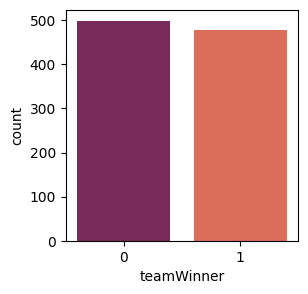

In [2]:
# verificando balanceamento dos dados entre as duas categorias
# possíveis do dataset
plt.figure(figsize = (3, 3))
sns.countplot(x=dados["teamWinner"], palette='rocket')

### 🟠 Escolha do Modelo

Para a escolha do modelo foi levado em consideração o boxplot com a média das acurácias e precisões que cada um dos algoritmos de classificação conseguiu, de forma a escolher o com maior acurácia e precisão, para posteriormente seus paramêtros serão variados para determinar o melhor ajuste.

In [3]:
# import dos modelos testados
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

# import da validação cruzada
from sklearn.model_selection import cross_val_score

In [4]:
import numpy as np

# criando uma máscara para gerar posições aleatórias
# da separação de dados de treino e teste
def separarTreinoTeste(dados):
    msk = np.random.rand(len(dados)) < 0.8
    treino = dados[msk]
    teste = dados[~msk]
    
    return treino, teste

In [5]:
# separação em treino e teste da base de dados e criação das colunas retiradas
treino, teste = separarTreinoTeste(dados)
xTreino = treino.drop('teamWinner', axis=1)
yTreino = treino['teamWinner']

<Axes: >

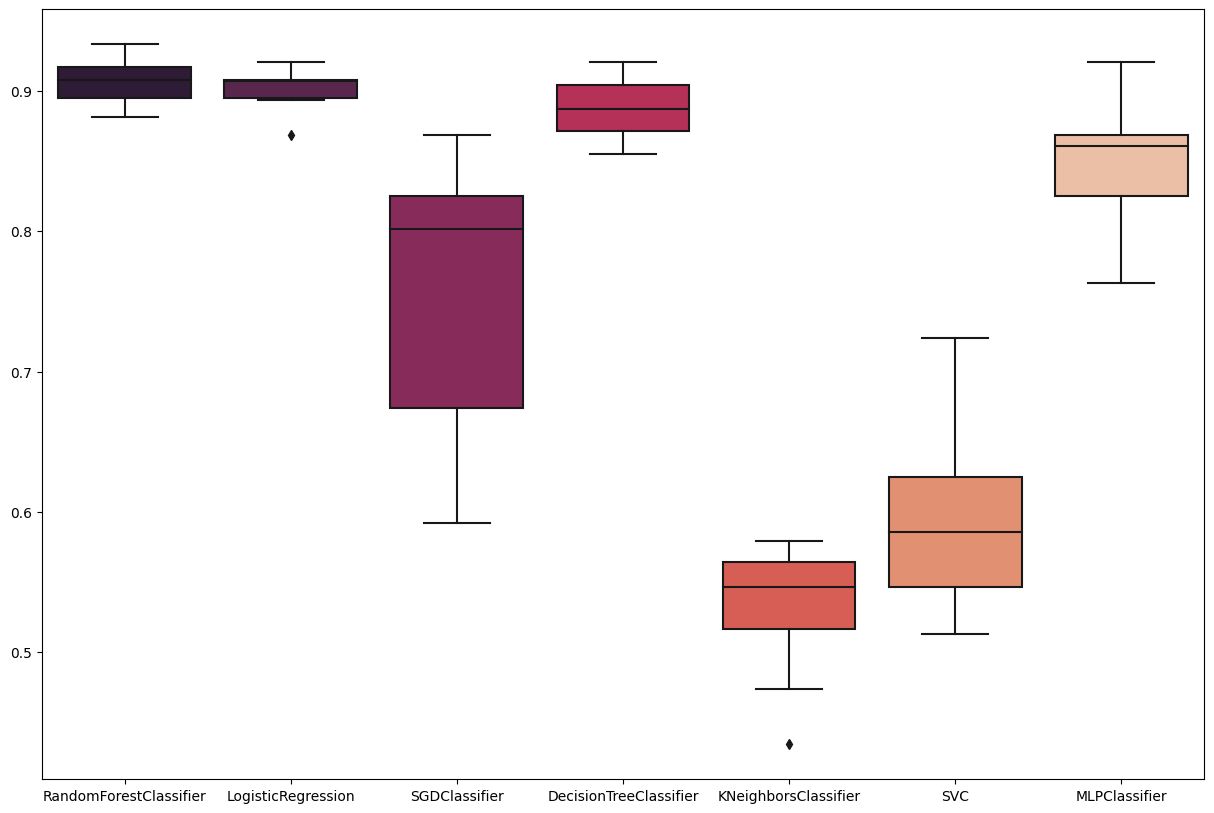

In [6]:
model = [RandomForestClassifier(),LogisticRegression(),SGDClassifier(),DecisionTreeClassifier(),KNeighborsClassifier(),SVC(),MLPClassifier()]
scores = {}
for i in model:
    scores[type(i).__name__] = cross_val_score(i, xTreino, yTreino, cv=10)

scores = pd.DataFrame.from_dict(scores)
plt.figure(figsize = (15,10))
sns.boxplot(data = scores, palette='rocket')

### 🟡 Classificação do Modelo

Como pode ser verificado no gráfico gerado anteriormente, o algoritmo com melhores métricas foi o **random forest**, dessa forma sendo feita uma verificação em várias formas de paramêtros do mesmo para determinar o com melhor resultado.

In [7]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier

# função para a execução dos resultados obtidos pelo random forest
def predicaoRandomForest(treino, teste, colunaTarget, maxDepth=10, nEstimators=100, criterion="gini"):
    xTreino = treino.drop(colunaTarget, axis=1)
    yTreino = treino[colunaTarget]
    xTeste = teste.drop(colunaTarget, axis=1)
    yTeste = teste[colunaTarget]
    xTreino.shape, yTreino.shape, xTeste.shape
    
    randomForest = RandomForestClassifier(n_estimators=nEstimators, max_depth=maxDepth, criterion=criterion, random_state=42)
    randomForest.fit(xTreino, yTreino)
    
    return randomForest

In [8]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn import metrics
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

def calcularMetricas(yTeste, predicao):
    # calculando a acurácia
    acuracia = accuracy_score(yTeste, predicao)
    
    # calculando a precisão
    precision = precision_score(yTeste, predicao)

    # calculando a revocação
    recall = recall_score(yTeste, predicao)

    # calculando o f1-score
    f1 = f1_score(yTeste, predicao)
    
    return acuracia, precision, recall, f1

In [9]:
def registroModelo(acuracia, precisao, recall, f1, modelo, nomeModelo, parametro1, nomeParametro1, parametro2, nomeParametro2, parametro3, nomeParametro3):
    with  mlflow.start_run(run_name=nomeModelo):
        # registro dos parâmetros
        mlflow.log_param(nomeParametro1, parametro1)
        mlflow.log_param(nomeParametro2, parametro2)
        mlflow.log_param(nomeParametro3, parametro3)
        
        # registro das métricas
        mlflow.log_metric("Acurácia", acuracia)
        mlflow.log_metric("Precisão", precisao)
        mlflow.log_metric("Recall", recall)
        mlflow.log_metric("F1-Score", f1)
        
        # registro do modelo
        mlflow.sklearn.log_model(modelo, "Modelo")
        mlflow.end_run()

In [10]:
import mlflow
import mlflow.sklearn

mlflow.set_tracking_uri('http://127.0.0.1:5000')
mlflow.set_experiment(experiment_name='Team Winner on Dota 2')

tags = {
        "Projeto": "Team Winner on Dota 2",
        "team": "Estela",
        "dataset": "dota2teamsprofessionals"
       }

In [11]:
# base de dados usados para a validação
treino, teste = separarTreinoTeste(dados)
treinoValidacao, validacao = separarTreinoTeste(treino)
xTeste = teste.drop('teamWinner', axis=1)
yTeste = teste['teamWinner']

criterios = ['gini', 'entropy']
estimators = [100, 150, 200]
maxDepth = [10, 15, 20]
cont = 0

for i in range(2):
    for j in range(3):
        for k in range(3):
            randomForest = predicaoRandomForest(treinoValidacao, validacao, 'teamWinner', maxDepth[k], estimators[j], criterios[i])
            predicao = randomForest.predict(xTeste)
            acuracia, precisao, recall, f1 = calcularMetricas(yTeste, predicao)
            
            print("Acurácia: "+str(acuracia))
            print()
            
            registroModelo(acuracia, precisao, recall, f1, randomForest, "Random Forest "+str(cont), estimators[j], "N-Estimators", criterios[i], "Critério", maxDepth[k], "Max Depth")
            cont += 1

Acurácia: 0.8947368421052632

Acurácia: 0.8894736842105263

Acurácia: 0.8894736842105263

Acurácia: 0.8947368421052632

Acurácia: 0.8947368421052632

Acurácia: 0.8947368421052632

Acurácia: 0.9105263157894737

Acurácia: 0.9

Acurácia: 0.9

Acurácia: 0.8842105263157894

Acurácia: 0.8842105263157894

Acurácia: 0.8842105263157894

Acurácia: 0.8894736842105263

Acurácia: 0.8947368421052632

Acurácia: 0.9

Acurácia: 0.9157894736842105

Acurácia: 0.9052631578947369

Acurácia: 0.9105263157894737



Verificando os resultados apresentados no MLFlow, e ordenando primeiramente pela acurácia, e depois pelo recall e pela precisão o melhor modelo ficou como definido sendo o que possui como critério entropy, com 200 estimators e 10 de altura máxima da árvore.

### 🟢 Verificação de Resultados Preditos

In [24]:
# colocando variavel com melhor resultado do algoritmo
randomForest = predicaoRandomForest(treinoValidacao, validacao, 'teamWinner', 10, 200, "entropy")
predicao = randomForest.predict(xTeste)
acuracia, precisao, recall, f1 = calcularMetricas(yTeste, predicao)

print(f'Acurácia: {acuracia}')
print(f'Precisão: {precisao}')
print(f'Recall: {recall}')
print(f'F1-Score: {f1}')

Acurácia: 0.9157894736842105
Precisão: 0.9438202247191011
Recall: 0.8842105263157894
F1-Score: 0.9130434782608695


In [25]:
array = [[1, 2, 3, 4, 5, 6, 7, 8, 9, 13, 4, 3, 3]]
randomForest.predict(array)[0]

1

In [26]:
array = [1, 2, 3, 4, 5, 6, 7, 8, 9, 13, 4, 3, 3]
dadosNovos = []
dadosNovos.append(0)
dadosNovos[0] = array

randomForest.predict(dadosNovos)[0]

1

In [27]:
randomForest.predict_proba([[1, 2, 3, 4, 5, 6, 7, 8, 9, 13, 4, 3, 3]])[0][1]

0.52